### Импорт пакетов

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize 
from nltk import ngrams 
import re

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### Загрузка и обработка данных

In [2]:
df = pd.read_excel('База данных.xlsx', sheet_name = 'Лист3', nrows=393)
df.sample(n=10)

,название,year,text,fraud
72,группа черкизово,2017,I am pleased to report that 2017 witnessed con...,0
282,россети центр и приволжье,2014,Energy Company JSC IDGC of Center and Volga Re...,1
114,россети центр и приволжье,2016,"Summarizing the outcome of 2016, we can say th...",1
236,мостотрест,2017,Kerch Bridge Construction Project 2017 Status ...,0
332,русгидро,2018,2018 marked yet another year for RusHydro Grou...,0
156,совкомфлот,2015,"In the reporting period, the SCF Group achieve...",0
360,россети московский регион,2017,"In 2017, the PJSC MOESK team was successful in...",0
85,фосагро,2020,"In 2020, the global community faced one of its...",0
278,огк-2,2019,OJSC OGK-2 implementing the Strategy of Gazpro...,0
385,россети центр,2020,"In 2020, despite the existing unbiased difficu...",0


In [3]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Загружаем стандартный список стоп-слов
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.remove('not')

In [4]:
# Добавляем в список стоп-слов названия стран
import pycountry 

for country in pycountry.countries:
    name = country.name.split(' ')
    for i in name:
        j = re.sub('[^A-Za-z]+', '', i)
        j = j.lower()
        if j not in stopwords:
            stopwords.append(j)

In [5]:
# Добавляем в список стоп-слов названия месяцев
import calendar

for month in list(calendar.month_name)[1:]:
    stopwords.append((month.lower()))

In [6]:
# Добавляем в список стоп-слов названия компаний и др. слова, 
# встречающиеся в текстах отчетов, которые можно отнести к стоп-словам

companies = ['group', 'pjsc', 'acron', 'sistema', 'aeroflot', 'beluga', 'gazprom', 'etalon',
             'lsr', 'cherkizovo', 'detsky', 'mir', 'evraz', 'lukoil', 'magnit', 'mvideo', 
             'eldorado', 'megafon', 'metalloinvest', 'mmk', 'mosenergo', 'mts', 'nlmk', 
             'novatek', 'nornickel', 'okey', 'polymetal', 'petropavlovsk', 'polyus', 
             'railways', 'rosatom', 'rosneft', 'rosseti', 'moesk', 'idgc', 'northern', 
             'caucasus', 'kuban', 'northwest', 'urals', 'center', 'volga', 'region', 
             'south', 'rostelecom', 'rostec', 'rusagro', 'rushydro', 'russneft', 'severstal', 
             'segezha', 'sovcomflot', 'suek', 'tatneft', 'tele', 'tmk', 'uralkali', 'phosagro', 
             'unipro', 'uniper', 'globaltrans', 'retail', 'x', 'synergy', 'oleniy', 'ruchey', 
             'kerch', 'safmar', 'russian', 'chinese', 'moscow', 'siberia', 'odintsovo', 
             'uk', 'us', 'usa', 'npp', 'due', 'two', 'russia', 'company', 'vorkutaugol',
            'c', 'second', 'harjavalta', 'dixy', 'fi', 'fy', 'ural', 'sverdlovsk', 'kubanenergo',
            'kv', 'rusal', 'nizhny', 'eu', 'hva', 'komi', 'one', 'kaluga', 'year', 'meat', 
             'passenger', 'oblast', 'nancial', 'pl', 'naletu', 'lenta', 'bristol', 'id', 
             'kirovsky', 'yandex', 'lavka', 'nd', 'aa', 'aaa', 'aac', 'ab', 'abc', 'ad', 
             'ag', 'ai', 'al', 'ano', 'ant', 'anton', 'antonina', 'antonios', 'antoniou', 
             'antonyan', 'ar', 'az', 'b', 'ba', 'baa', 'bb', 'bbb', 'bdd', 'bboe', 'bi', 'bf']

for company in companies:
    stopwords.append(company)

In [7]:
def data_preprocessing(text): 
    # очистка данных
    text = re.sub(re.compile('<.*?>'), '', text) 
    text =  re.sub('[^A-Za-z]+', ' ', text) 
    
    # приводим все к нижнему регистру
    text = text.lower()
    # приводим слова к токенам
    tokens = nltk.word_tokenize(text)
    # удаляем стоп-слова
    text = [word for word in tokens if word not in stopwords]
    # лемматизация
    text = [lemmatizer.lemmatize(word) for word in text]
    # соединяем слова обратно в текст
    text = ' '.join(text)
    
    return text

In [8]:
df['preprocessed_text'] = df['text'].apply(lambda text: data_preprocessing(text))
df.head()

,название,year,text,fraud,preprocessed_text
0,евраз,2018,2018 was a robust year for the business reinfo...,0,robust business reinforced strong global metal...
1,русснефть,2018,"In 2018, RussNeft consolidated the achievement...",1,consolidated achievement making steadily past ...
2,ростелеком,2017,"Through staying ahead of the curve, rapidly ad...",1,staying ahead curve rapidly adapting economic ...
3,северсталь,2018,"In 2018, Severstal reaffirmed its position as ...",0,reaffirmed position industry leader strong tra...
4,газпром,2016,2016 was a challenging year for the global ene...,1,challenging global energy industry number macr...


In [9]:
df_vect = pd.DataFrame()
df_vect['text'] = df['preprocessed_text']
df_vect['fraud'] = df['fraud']

df_vect.to_csv('data_vectorized_text.csv')

In [10]:
#words_list = df[df['fraud']==1]['preprocessed_text'].unique().tolist()
#fraud_words = " ".join(words_list)

#fraud_wordcloud = WordCloud(
#                  width=800, height = 500,            
#                  stopwords=stopwords).generate(fraud_words)

#plt.figure(figsize=(8, 8), facecolor = None)
#plt.imshow(fraud_wordcloud)
#plt.axis("off")
#plt.tight_layout(pad=0)
#plt.show()

In [11]:
#words_list1 = df[df['fraud']==0]['preprocessed_text'].unique().tolist()
#fraud_words1 = " ".join(words_list1)

#fraud_wordcloud1 = WordCloud(
#                  width=800, height = 500,            
#                  stopwords=stopwords).generate(fraud_words1)

#plt.figure(figsize=(8, 8), facecolor = None)
#plt.imshow(fraud_wordcloud1)
#plt.axis("off")
#plt.tight_layout(pad=0)
#plt.show()

### Описательная статистика

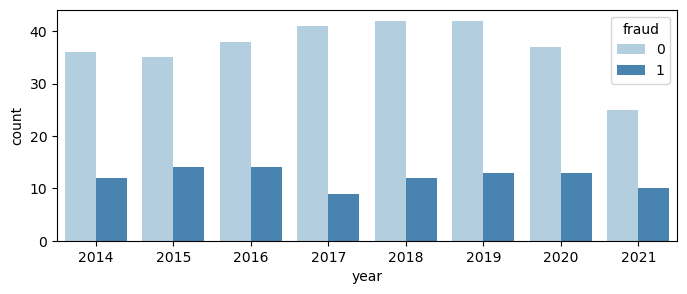

In [12]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.countplot(x='year', hue='fraud', data=df, palette = 'Blues', ax = ax);

### Обучение моделей

In [32]:
x = df.preprocessed_text
y = df.fraud

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
x_train

364    undoubtfully brought unprecedented challenge s...
180    reinforced leading position despite challengin...
119    another growth demonstrated solid performance ...
374    leading way social development committed suppo...
219    past true ordeal whole world covid pandemic br...
                             ...                        
71     key player alcoholic beverage sector economy i...
106    pleasure welcome annual report coronavirus pan...
270    pleased report achieved around target gain fir...
348    delighted report another successful performanc...
102    eventful challenging key sector whole sector c...
Name: preprocessed_text, Length: 263, dtype: object

**Инициализируем два метода векторизации текста**

In [33]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1), 
                                   tokenizer=word_tokenize, 
                                   stop_words=stopwords)

count_vectorized_x_train = count_vectorizer.fit_transform(x_train)
count_vectorized_x_test = count_vectorizer.transform(x_test)

count_vectorized_x = count_vectorizer.transform(x)

In [34]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                                   tokenizer=word_tokenize, 
                                   stop_words=stopwords)
tfidf_vectorized_x_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_vectorized_x_test = tfidf_vectorizer.transform(x_test)

tfidf_vectorized_x = tfidf_vectorizer.transform(x)

### Логистическая регрессия

**Логистическая регрессия + count_vectorizer**

In [113]:
log1 = LogisticRegression(random_state=42)
log1.fit(count_vectorized_x_train, y_train)

pred_log1 = log1.predict(count_vectorized_x_test)
print(f1_score(y_test, pred_log1, average=None))

[0.83253589 0.31372549]


In [114]:
params = {'penalty' : ['l1', 'l2', 'elasticnet'],
         'solver': ['sag', 'saga', 'lbfgs'],
         'C': np.arange(1,100,1)}

log1_cv = GridSearchCV(log1, params, cv = 3 scoring = 'recall')
log1_cv.fit(count_vectorized_x, y)

print('Best params:', log1_cv.best_params_)
print('Best Score:', log1_cv.best_score_)

Best params: {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
Best Score: 0.7786259541984734


**Логистическая регрессия + tf_idf**

In [115]:
log2 = LogisticRegression(random_state=42)
log2.fit(tfidf_vectorized_x_train, y_train)

pred_log2 = log2.predict(tfidf_vectorized_x_test)
print(f1_score(y_test, pred_log2, average=None))

[0.87336245 0.06451613]


In [116]:
params = {'penalty' : ['l1', 'l2', 'elasticnet'],
         'solver': ['sag', 'saga', 'lbfgs'],
         'C': np.arange(1,100,1)}

log2_cv = GridSearchCV(log2, params, cv = 3, scoring = 'recall')
log2_cv.fit(tfidf_vectorized_x, y)

print('Best params:', log2_cv.best_params_)
print('Best Score:', log2_cv.best_score_)

Best params: {'C': 7, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.7837150127226463


### Оптимальная модель log

In [117]:
log_optimal = LogisticRegression(random_state=42, solver='saga', C=7, penalty='l2')
log_optimal.fit(tfidf_vectorized_x_train, y_train)

pred_log_test = log_optimal.predict(tfidf_vectorized_x_test)
print(f1_score(y_test, pred_log_test, average=None))

[0.88181818 0.35      ]


In [118]:
pred_log_optimal = log_optimal.predict(tfidf_vectorized_x)

**Подсчет метрик качества**

0.9050048760100305

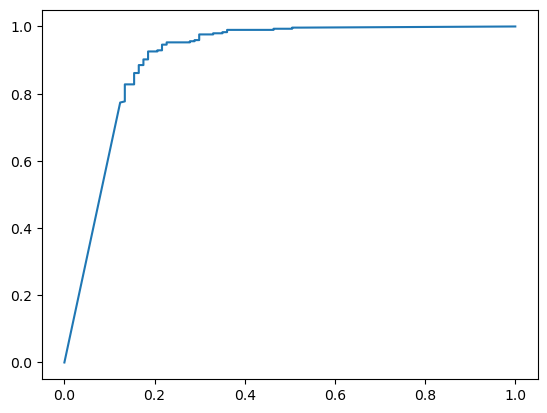

In [119]:
tpr, fpr, _ = roc_curve(y, log_optimal.predict_proba(count_vectorized_x)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.6676666666666666

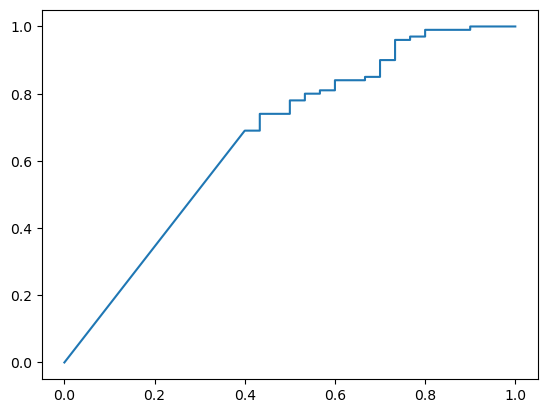

In [120]:
tpr, fpr, _ = roc_curve(y_test, log_optimal.predict_proba(count_vectorized_x_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [121]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

print('Accuracy:', accuracy_score(y_test, pred_log_test))
print('Precision:', precision_score(y_test, pred_log_test))
print('Recall:', recall_score(y_test, pred_log_test))
print('F1-score:', f1_score(y_test, pred_log_test))

Accuracy: 0.8
Precision: 0.7
Recall: 0.23333333333333334
F1-score: 0.35


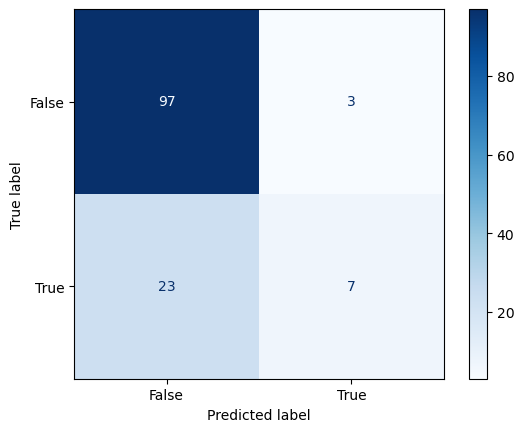

In [122]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, pred_log_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

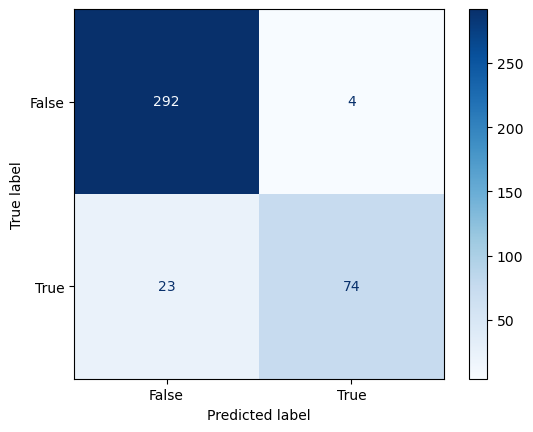

In [123]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, pred_log_optimal)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [124]:
FP = confusion_matrix.sum(axis=0)[1] - np.diag(confusion_matrix)[1]  
FN = confusion_matrix.sum(axis=0)[0] - np.diag(confusion_matrix)[0]  
TN = np.diag(confusion_matrix)[0]
TP = np.diag(confusion_matrix)[1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print('Доля выявленного мошенничества:', TPR)
print('Доля предсказанного верно мошенничества:', PPV)

Доля выявленного мошенничества: 0.7628865979381443
Доля предсказанного верно мошенничества: 0.9487179487179487


**Облако слов**

In [125]:
feature_to_coef_log = { word: coef for word, coef in zip(tfidf_vectorizer.get_feature_names_out(), log_optimal.coef_[0]) }

fraudwords = []
nonfraudwords = []
for best_positive in sorted(feature_to_coef_log.items(), key=lambda x: x[1], reverse=True):
    if best_positive[1] <= 0:
        nonfraudwords.append(best_positive[0])
    if best_positive[1] > 0:
        fraudwords.append(best_positive[0])

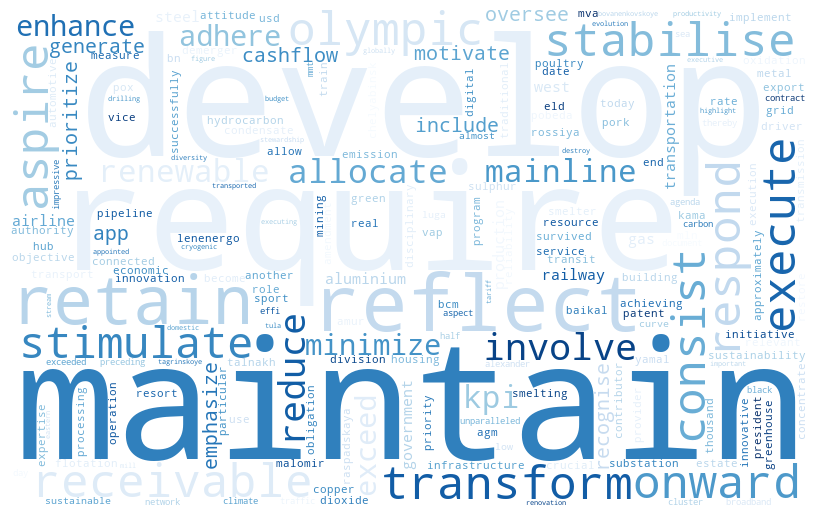

In [126]:
from wordcloud import WordCloud

fraud_words1 = " ".join(fraudwords)

fraud_wordcloud1 = WordCloud(
                  width=800, height = 500,
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(fraud_words1)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(fraud_wordcloud1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

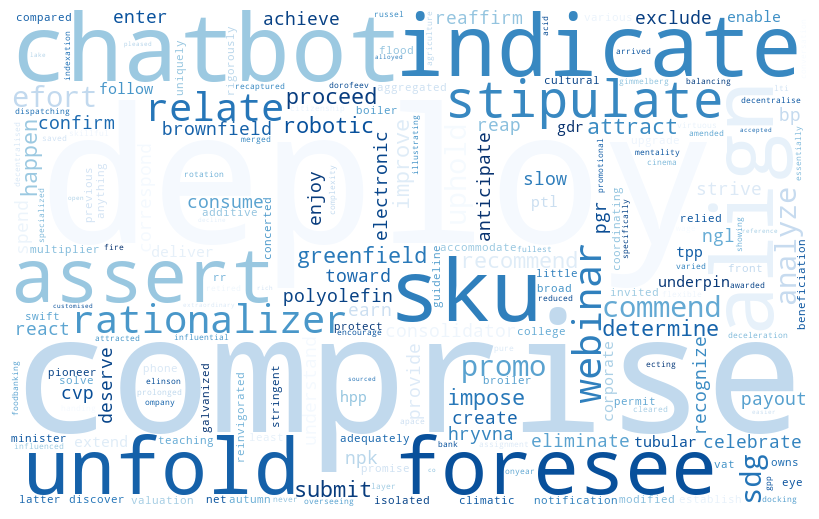

In [127]:
nonfraud_words1 = " ".join(nonfraudwords)

nonfraud_wordcloud1 = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(nonfraud_words1)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(nonfraud_wordcloud1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Decision tree

**Дерево решений + count_vectorizer**

In [147]:
tree1 = DecisionTreeClassifier(random_state=42)
tree1.fit(count_vectorized_x_train, y_train)

pred_tree1 = tree1.predict(count_vectorized_x_test)
print(f1_score(y_test, pred_tree1, average=None))

[0.82857143 0.28      ]


In [148]:
params = {'max_features' : ['sqrt', 'log2'],
          'max_depth': np.arange(1,50),
          'criterion': ['gini', 'entropy', 'log_loss']}

tree1 = DecisionTreeClassifier(random_state=42) 

tree1_cv = GridSearchCV(tree1, params, cv = 3, scoring = 'recall')
tree1_cv.fit(count_vectorized_x, y)

print('Best params:', tree1_cv.best_params_)
print('Best Score:', tree1_cv.best_score_)

Best params: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt'}
Best Score: 0.36621157876104177


**Дерево решений + tf_idf**

In [149]:
tree2 = DecisionTreeClassifier(random_state=42)
tree2.fit(tfidf_vectorized_x_train, y_train)

pred_tree2 = tree2.predict(tfidf_vectorized_x_test)
print(f1_score(y_test, pred_tree2, average=None))

[0.78172589 0.31746032]


In [150]:
params = {'max_features' : ['sqrt', 'log2'],
          'max_depth': np.arange(1,50),
          'criterion': ['gini', 'entropy', 'log_loss']}

tree2 = DecisionTreeClassifier(random_state=42) 

tree2_cv = GridSearchCV(tree2, params, cv = 3, scoring = 'recall')
tree2_cv.fit(tfidf_vectorized_x, y)

print('Best params:', tree2_cv.best_params_)
print('Best Score:', tree2_cv.best_score_)

Best params: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 'log2'}
Best Score: 0.3468137254901961


### Оптимальная модель tree

In [151]:
tree_optimal = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=20, max_features = 'sqrt')
tree_optimal.fit(count_vectorized_x_train, y_train)

pred_tree_test = tree_optimal.predict(count_vectorized_x_test)
print(f1_score(y_test, pred_tree_test, average=None))

[0.83962264 0.29166667]


In [152]:
pred_tree_optimal = tree_optimal.predict(count_vectorized_x)

**Подсчет метрик качества**

0.8738958269875114

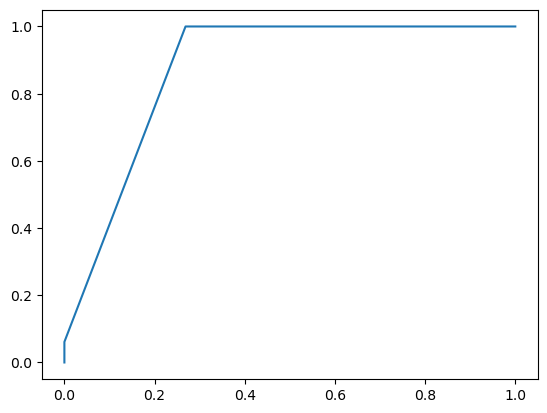

In [153]:
tpr, fpr, _ = roc_curve(y_train, tree_optimal.predict_proba(count_vectorized_x_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.5698333333333333

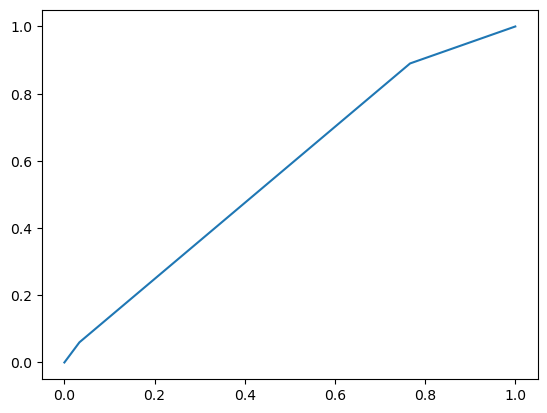

In [154]:
tpr, fpr, _ = roc_curve(y_test, tree_optimal.predict_proba(count_vectorized_x_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [155]:
print('Accuracy test:', accuracy_score(y_test, pred_tree_test))
print('Precision test:', precision_score(y_test, pred_tree_test))
print('Recall test:', recall_score(y_test, pred_tree_test))
print('F1-score test:', f1_score(y_test, pred_tree_test))

Accuracy test: 0.7384615384615385
Precision test: 0.3888888888888889
Recall test: 0.23333333333333334
F1-score test: 0.2916666666666667


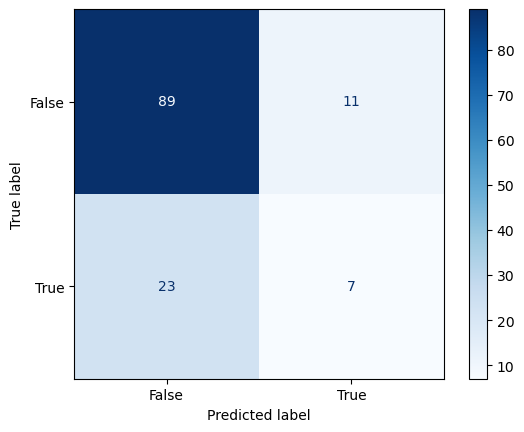

In [156]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, pred_tree_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

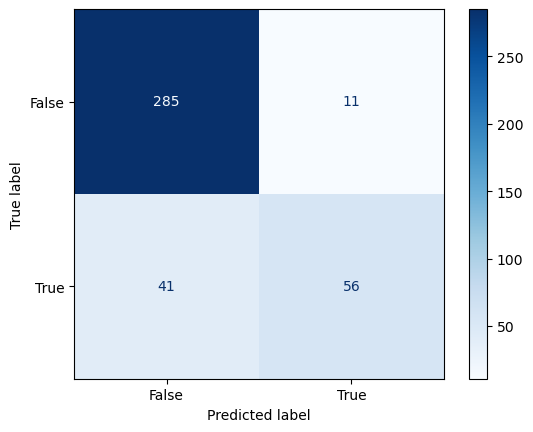

In [157]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, pred_tree_optimal)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [158]:
FP = confusion_matrix.sum(axis=0)[1] - np.diag(confusion_matrix)[1]  
FN = confusion_matrix.sum(axis=0)[0] - np.diag(confusion_matrix)[0]  
TN = np.diag(confusion_matrix)[0]
TP = np.diag(confusion_matrix)[1]

TPR = TP/(TP+FN)
PPV = TP/(TP+FP)

print('Доля выявленного мошенничества:', TPR)
print('Доля предсказанного верно мошенничества:', PPV)

Доля выявленного мошенничества: 0.5773195876288659
Доля предсказанного верно мошенничества: 0.835820895522388


**Облако слов**

In [160]:
feature_to_coef_tree = { word: coef for word, coef in zip(count_vectorizer.get_feature_names_out(), tree_optimal.feature_importances_) }

fraudwords = []
nonfraudwords = []
for best_positive in sorted(feature_to_coef_tree.items(), key=lambda x: x[1], reverse=True):
    if best_positive[1] <= 0:
        nonfraudwords.append(best_positive[0])
    if best_positive[1] > 0:
        fraudwords.append(best_positive[0])

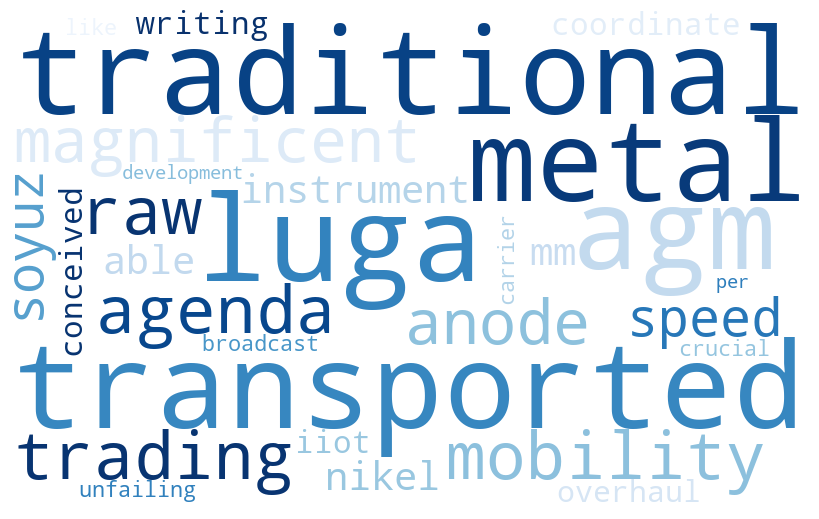

In [161]:
words = " ".join(fraudwords)

wordcloud = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(words)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

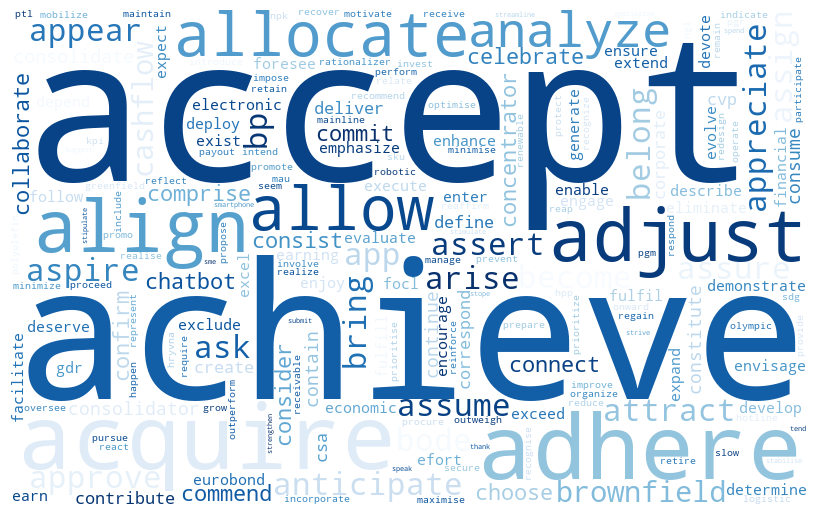

In [162]:
words = " ".join(nonfraudwords)

wordcloud = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(words)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### SGD

**Стохастический градиентный спуск + count_vectorizer**

In [170]:
sgd1 = SGDClassifier()
sgd1.fit(count_vectorized_x_train, y_train)

pred_sgd1 = sgd1.predict(count_vectorized_x_test)
print(f1_score(y_test, pred_sgd1, average=None))

[0.88038278 0.50980392]


In [171]:
params = {'loss': ['log_loss', 'modified_huber'],
         'penalty': ['l2', 'l1', 'elasticnet']}

sgd1_cv = GridSearchCV(sgd1, params, cv = 3, scoring = 'recall')
sgd1_cv.fit(count_vectorized_x, y)

print('Best params:', sgd1_cv.best_params_)
print('Best Score:', sgd1_cv.best_score_)

Best params: {'loss': 'log_loss', 'penalty': 'l2'}
Best Score: 0.4504982535189


**Стохастический градиентный спуск + tf_idf**

In [172]:
sgd2 = SGDClassifier()
sgd2.fit(tfidf_vectorized_x_train, y_train)

pred_sgd2 = sgd2.predict(tfidf_vectorized_x_test)
print(f1_score(y_test, pred_sgd2, average=None))

[0.87037037 0.36363636]


In [173]:
params = {'loss': ['log_loss', 'modified_huber'],
         'penalty': ['l2', 'l1', 'elasticnet']}

sgd2_cv = GridSearchCV(sgd2, params, cv = 3, scoring = 'recall')
sgd2_cv.fit(tfidf_vectorized_x, y)

print('Best params:', sgd2_cv.best_params_)
print('Best Score:', sgd2_cv.best_score_)

Best params: {'loss': 'modified_huber', 'penalty': 'elasticnet'}
Best Score: 0.4461723638013713


### Оптимальная модель sgd

**Первая:**

In [182]:
sgd_optimal = SGDClassifier(random_state=42, loss='log_loss', penalty='l2')
sgd_optimal.fit(count_vectorized_x_train, y_train)

pred_sgd_test = sgd_optimal.predict(count_vectorized_x_test)
print(f1_score(y_test, pred_sgd_optimal, average=None))

[0.84615385 0.38461538]


In [183]:
pred_sgd_optimal = sgd_optimal.predict(count_vectorized_x)

**Подсчет метрик качества**

1.0

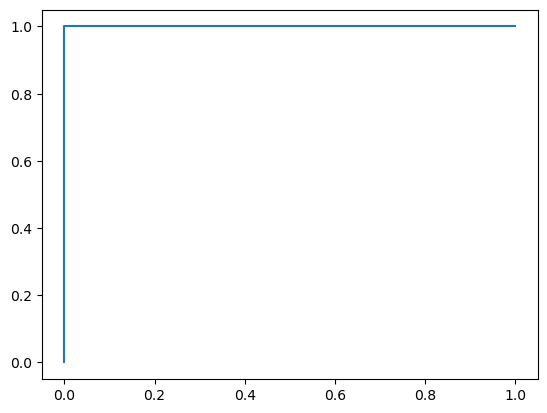

In [184]:
tpr, fpr, _ = roc_curve(y_train, sgd_optimal.predict_proba(count_vectorized_x_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.6198333333333333

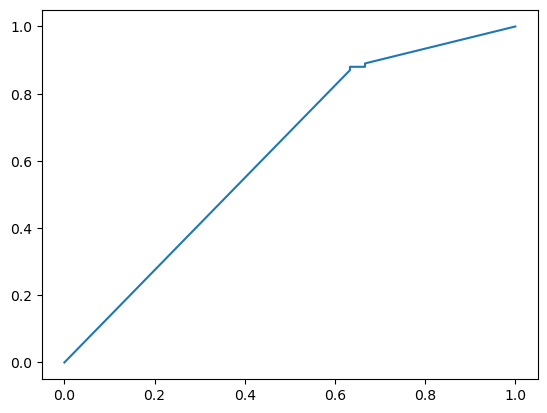

In [185]:
tpr, fpr, _ = roc_curve(y_test, sgd_optimal.predict_proba(count_vectorized_x_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [187]:
print('Accuracy test:', accuracy_score(y_test, pred_sgd_test))
print('Precision test:', precision_score(y_test, pred_sgd_test))
print('Recall test:', recall_score(y_test, pred_sgd_test))
print('F1-score test:', f1_score(y_test, pred_sgd_test))

Accuracy test: 0.7538461538461538
Precision test: 0.45454545454545453
Recall test: 0.3333333333333333
F1-score test: 0.3846153846153846


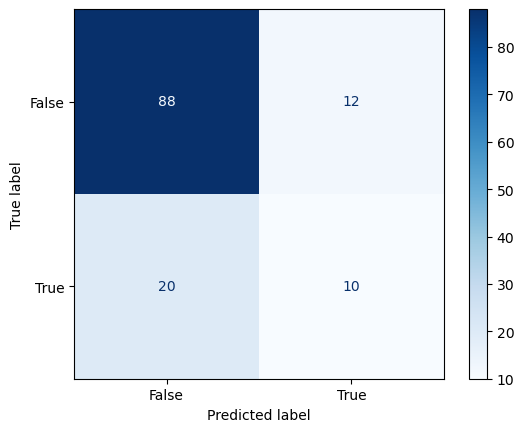

In [188]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, pred_sgd_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

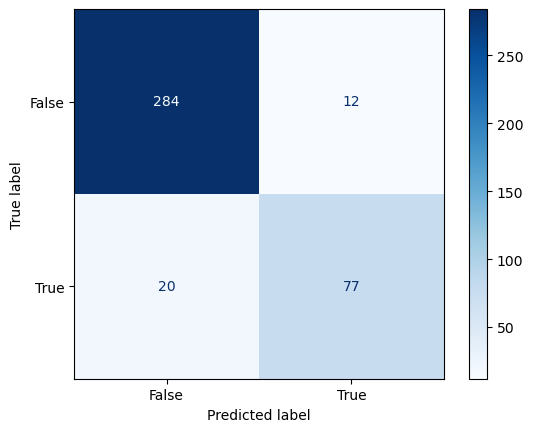

In [189]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, pred_sgd_optimal)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [190]:
FP = confusion_matrix.sum(axis=0)[1] - np.diag(confusion_matrix)[1]  
FN = confusion_matrix.sum(axis=0)[0] - np.diag(confusion_matrix)[0]  
TN = np.diag(confusion_matrix)[0]
TP = np.diag(confusion_matrix)[1]

TPR = TP/(TP+FN)
PPV = TP/(TP+FP)

print('Доля выявленного мошенничества:', TPR)
print('Доля предсказанного верно мошенничества:', PPV)

Доля выявленного мошенничества: 0.7938144329896907
Доля предсказанного верно мошенничества: 0.8651685393258427


**Облако слов**

In [191]:
feature_to_coef_sgd = { word: coef for word, coef in zip(count_vectorizer.get_feature_names_out(), sgd_optimal.coef_[0]) }

fraudwords = []
nonfraudwords = []
for best_positive in sorted(feature_to_coef_sgd.items(), key=lambda x: x[1], reverse=True):
    if best_positive[1] <= 0:
        nonfraudwords.append(best_positive[0])
    if best_positive[1] > 0:
        fraudwords.append(best_positive[0])

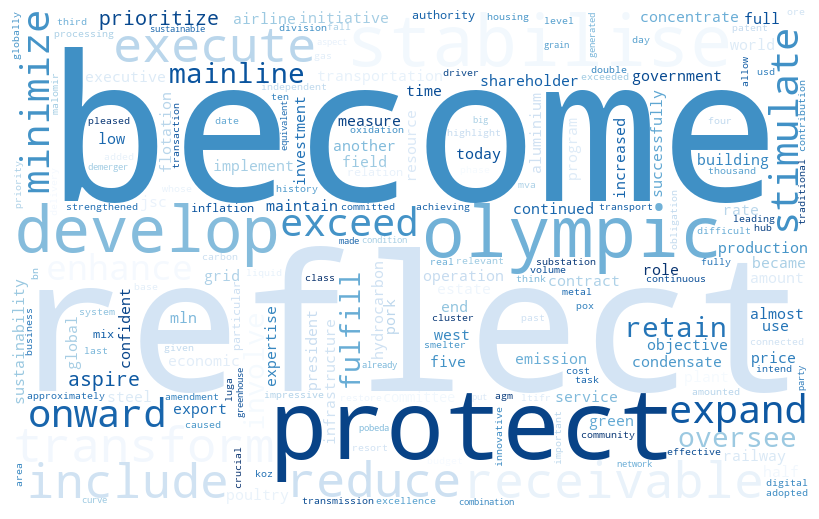

In [192]:
wordsf = " ".join(fraudwords)

wordcloudf = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsf)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudf)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

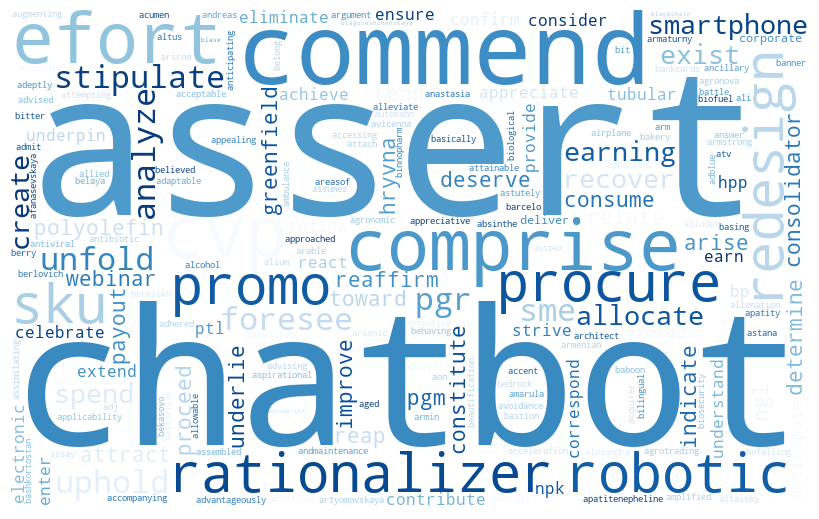

In [193]:
wordsn = " ".join(nonfraudwords)

wordcloudn = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsn)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudn)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Вторая:**

In [195]:
sgd_optimal1 = SGDClassifier(random_state=42, loss='modified_huber', penalty='elasticnet')
sgd_optimal1.fit(tfidf_vectorized_x_train, y_train)

pred_sgd_test1 = sgd_optimal1.predict(tfidf_vectorized_x_test)
print(f1_score(y_test, pred_sgd_optimal1, average=None))

[0.85446009 0.34042553]


In [196]:
pred_sgd_optimal1 = sgd_optimal1.predict(tfidf_vectorized_x)

**Подсчет метрик качества**

1.0

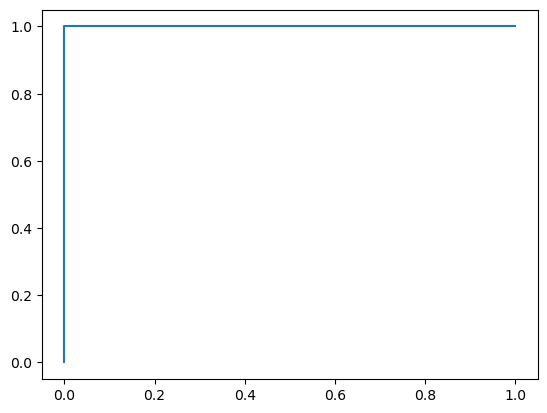

In [198]:
tpr, fpr, _ = roc_curve(y_train, sgd_optimal1.predict_proba(tfidf_vectorized_x_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.6023333333333334

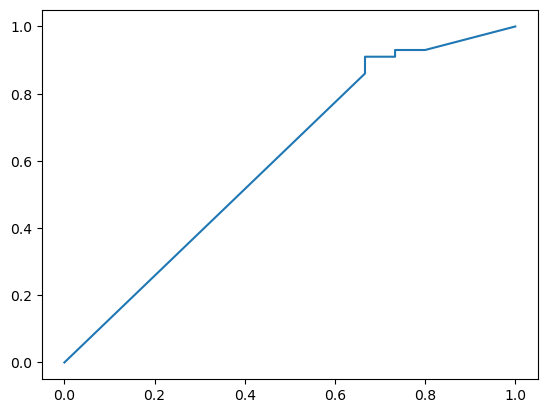

In [197]:
tpr, fpr, _ = roc_curve(y_test, sgd_optimal1.predict_proba(tfidf_vectorized_x_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [200]:
print('Accuracy test:', accuracy_score(y_test, pred_sgd_test1))
print('Precision test:', precision_score(y_test, pred_sgd_test1))
print('Recall test:', recall_score(y_test, pred_sgd_test1))
print('F1-score test:', f1_score(y_test, pred_sgd_test1))

Accuracy test: 0.7615384615384615
Precision test: 0.47058823529411764
Recall test: 0.26666666666666666
F1-score test: 0.3404255319148936


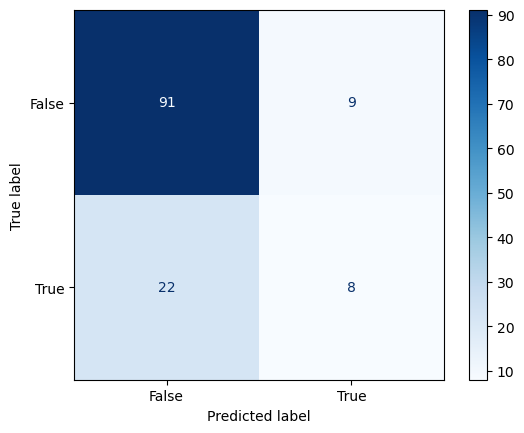

In [202]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, pred_sgd_test1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

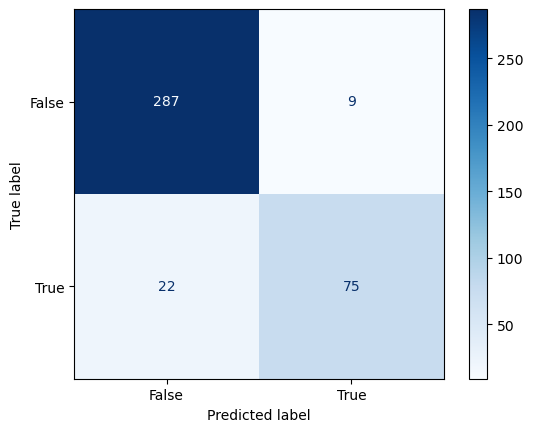

In [201]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, pred_sgd_optimal1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [203]:
FP = confusion_matrix.sum(axis=0)[1] - np.diag(confusion_matrix)[1]  
FN = confusion_matrix.sum(axis=0)[0] - np.diag(confusion_matrix)[0]  
TN = np.diag(confusion_matrix)[0]
TP = np.diag(confusion_matrix)[1]

TPR = TP/(TP+FN)
PPV = TP/(TP+FP)

print('Доля выявленного мошенничества:', TPR)
print('Доля предсказанного верно мошенничества:', PPV)

Доля выявленного мошенничества: 0.26666666666666666
Доля предсказанного верно мошенничества: 0.47058823529411764


**Облако слов:**

In [204]:
feature_to_coef_sgd1 = { word: coef for word, coef in zip(tfidf_vectorizer.get_feature_names_out(), sgd_optimal1.coef_[0]) }

fraudwords = []
nonfraudwords = []
for best_positive in sorted(feature_to_coef_sgd1.items(), key=lambda x: x[1], reverse=True):
    if best_positive[1] <= 0:
        nonfraudwords.append(best_positive[0])
    if best_positive[1] > 0:
        fraudwords.append(best_positive[0])

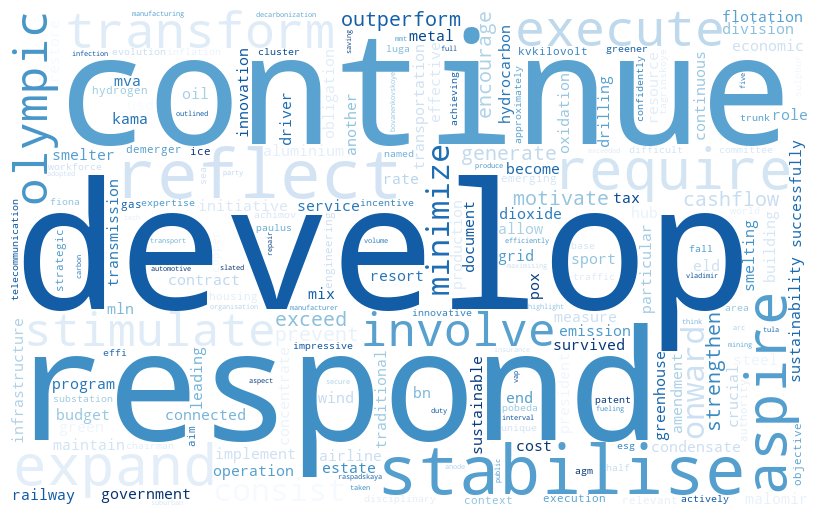

In [205]:
wordsf = " ".join(fraudwords)

wordcloudf = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsf)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudf)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

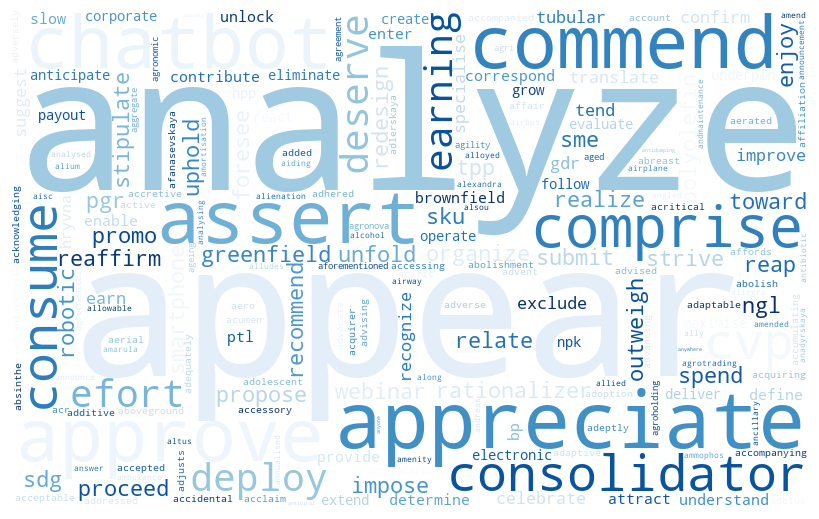

In [206]:
wordsn = " ".join(nonfraudwords)

wordcloudn = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsn)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudn)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### SVM

**Метод опорных векторов + count_vectorizer**

In [207]:
svm1 = SVC()
svm1.fit(count_vectorized_x_train, y_train)

pred_svm1 = svm1.predict(count_vectorized_x_test)
print(f1_score(y_test, pred_svm1, average=None))

[0.88105727 0.18181818]


In [208]:
pred_svm1_test = svm1.predict(count_vectorized_x)

In [209]:
params = {'C': np.arange(1,100,1),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svm1_cv = GridSearchCV(svm1, params, cv = 3, scoring = 'recall')
svm1_cv.fit(count_vectorized_x, y)

print('Best params:', svm1_cv.best_params_)
print('Best Score:', svm1_cv.best_score_)

Best params: {'C': 8, 'kernel': 'rbf'}
Best Score: 0.4737654320987654


**Метод опорных векторов + tf_idf**

In [210]:
svm2 = SVC()
svm2.fit(tfidf_vectorized_x_train, y_train)

pred_svm2 = svm2.predict(tfidf_vectorized_x_test)
print(f1_score(y_test, pred_svm2, average=None))

[0.87719298 0.125     ]


In [211]:
pred_svm2_test = svm2.predict(tfidf_vectorized_x)

In [212]:
params = {'C': np.arange(1,100,1),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svm2_cv = GridSearchCV(svm2, params, cv = 3, scoring = 'recall')
svm2_cv.fit(tfidf_vectorized_x, y)

print('Best params:', svm2_cv.best_params_)
print('Best Score:', svm2_cv.best_score_)

Best params: {'C': 11, 'kernel': 'sigmoid'}
Best Score: 0.513931488336565


In [228]:
params = {'C': np.arange(0.01,0.1,0.01),
          'kernel': ['linear']}

svm01_cv = GridSearchCV(svm1, params, cv = 3, scoring = 'recall')
svm01_cv.fit(count_vectorized_x, y)

print('Best params:', svm01_cv.best_params_)
print('Best Score:', svm01_cv.best_score_)

Best params: {'C': 0.01, 'kernel': 'linear'}
Best Score: 0.4708133971291866


### Оптимальная модель svm

In [217]:
svm_optimal = SVC(random_state=42, C=11, kernel='sigmoid', probability = True)
svm_optimal.fit(tfidf_vectorized_x_train, y_train)

pred_svm_test = svm_optimal.predict(tfidf_vectorized_x_test)
print(f1_score(y_test, pred_svm_test, average=None))

[0.82926829 0.36363636]


In [218]:
pred_svm_optimal = svm_optimal.predict(tfidf_vectorized_x)

**Подсчет метрик качества**

1.0

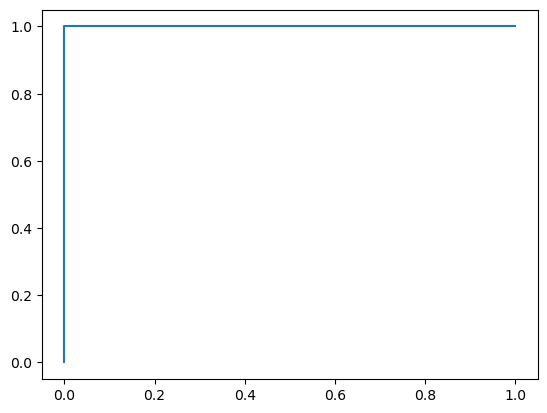

In [221]:
tpr, fpr, _ = roc_curve(y_train, svm_optimal.predict_proba(tfidf_vectorized_x_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.6646666666666666

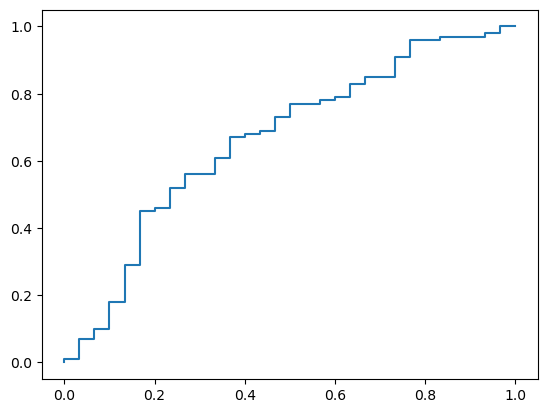

In [220]:
tpr, fpr, _ = roc_curve(y_test, svm_optimal.predict_proba(tfidf_vectorized_x_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [222]:
print('Accuracy test:', accuracy_score(y_test, pred_svm_test))
print('Precision test:', precision_score(y_test, pred_svm_test))
print('Recall test:', recall_score(y_test, pred_svm_test))
print('F1-score test:', f1_score(y_test, pred_svm_test))

Accuracy test: 0.7307692307692307
Precision test: 0.4
Recall test: 0.3333333333333333
F1-score test: 0.3636363636363636


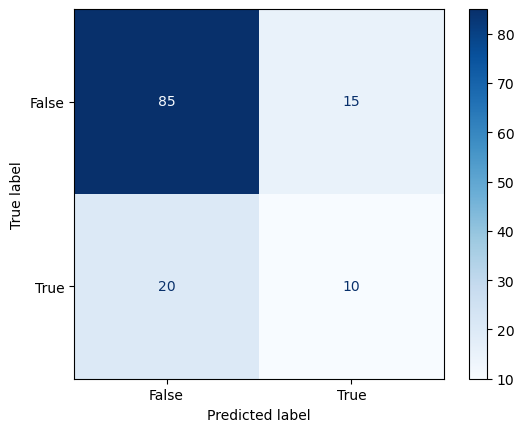

In [223]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, pred_svm_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

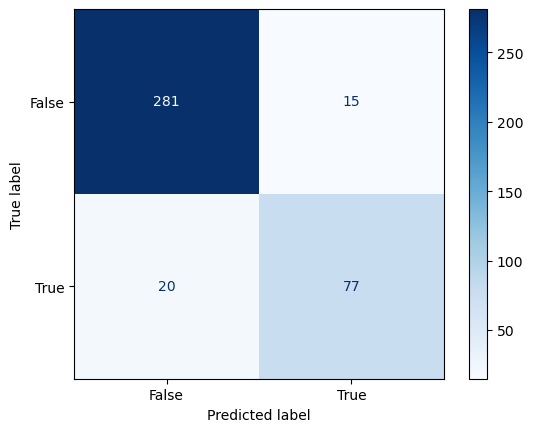

In [224]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, pred_svm_optimal)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [225]:
FP = confusion_matrix.sum(axis=0)[1] - np.diag(confusion_matrix)[1]  
FN = confusion_matrix.sum(axis=0)[0] - np.diag(confusion_matrix)[0]  
TN = np.diag(confusion_matrix)[0]
TP = np.diag(confusion_matrix)[1]

TPR = TP/(TP+FN)
PPV = TP/(TP+FP)

print('Доля выявленного мошенничества:', TPR)
print('Доля предсказанного верно мошенничества:', PPV)

Доля выявленного мошенничества: 0.7938144329896907
Доля предсказанного верно мошенничества: 0.8369565217391305


**Облако слов**

In [229]:
svm_linear = SVC(random_state=42, C=0.01, kernel='linear')
svm_linear.fit(count_vectorized_x_train, y_train)

pred_svm_linear = svm_linear.predict(count_vectorized_x_test)
print(f1_score(y_test, pred_svm_linear, average=None))

[0.82587065 0.40677966]


In [230]:
feature_to_coef_svm = { word: coef for word, coef in zip(count_vectorizer.get_feature_names_out(), svm_linear.coef_.toarray()[0]) }

fraudwords = []
nonfraudwords = []
for best_positive in sorted(feature_to_coef_svm.items(), key=lambda x: x[1], reverse=True):
    if best_positive[1] <= 0:
        nonfraudwords.append(best_positive[0])
    if best_positive[1] > 0:
        fraudwords.append(best_positive[0])

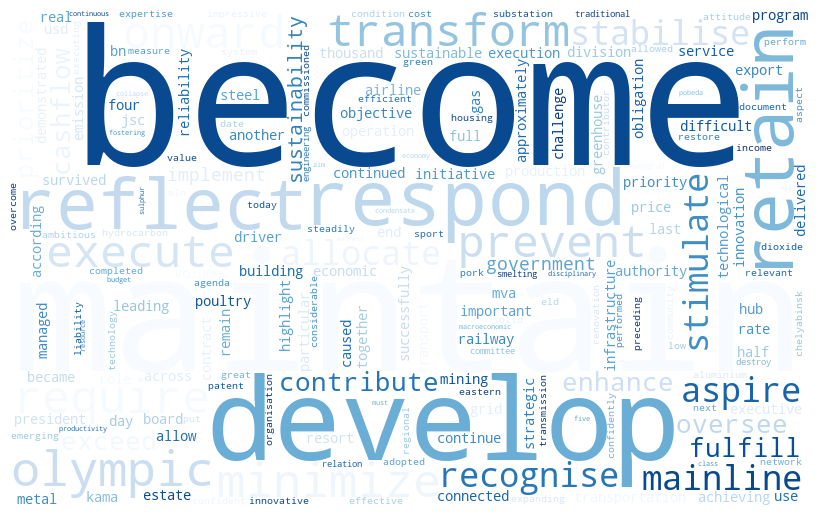

In [231]:
wordsf = " ".join(fraudwords)

wordcloudf = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsf)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudf)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

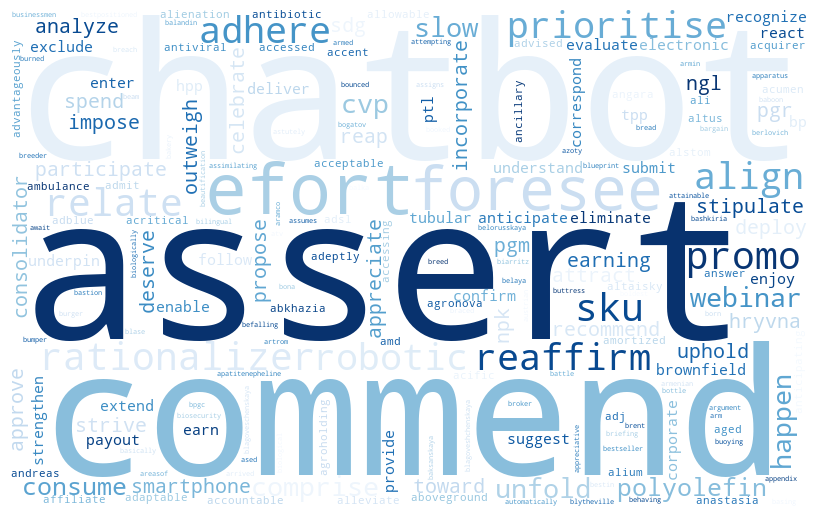

In [232]:
wordsn = " ".join(nonfraudwords)

wordcloudn = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsn)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudn)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Gradient boosting

**Градиентный бустинг + count_vectorizer**

In [233]:
boost1 = GradientBoostingClassifier()
boost1.fit(count_vectorized_x_train, y_train)

pred_boost1 = boost1.predict(count_vectorized_x_test)
print(f1_score(y_test, pred_boost1, average=None))

[0.86842105 0.0625    ]


In [234]:
pred_boost1_test = boost1.predict(count_vectorized_x)

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [235]:
params = {'n_estimators': np.arange(50,150,1)}

boost1_cv = GridSearchCV(boost1, params, cv = 3, scoring = 'recall')
boost1_cv.fit(tfidf_vectorized_x, y)

print('Best params:', boost1_cv.best_params_)
print('Best Score:', boost1_cv.best_score_)

Best params: {'n_estimators': 107}
Best Score: 0.29488279016580904


In [241]:
params = {'max_features': ['sqrt', 'log2'],
         'criterion': ['friedman_mse', 'squared_error', 'mse']}

boost01 = GradientBoostingClassifier(n_estimators = 107)

boost01_cv = GridSearchCV(boost01, params, cv = 3, scoring = 'recall')
boost01_cv.fit(count_vectorized_x, y)

print('Best params:', boost01_cv.best_params_)
print('Best Score:', boost01_cv.best_score_)

Best params: {'criterion': 'squared_error', 'max_features': 'sqrt'}
Best Score: 0.21732258574363836


**Градиентный бустинг + tf_idf**

In [237]:
boost2 = GradientBoostingClassifier()
boost2.fit(tfidf_vectorized_x_train, y_train)

pred_boost2 = boost2.predict(tfidf_vectorized_x_test)
print(f1_score(y_test, pred_boost2, average=None))

[0.88105727 0.18181818]


In [238]:
pred_boost2_test = boost2.predict(tfidf_vectorized_x)

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [239]:
params = {'n_estimators': np.arange(0,100,1)}

boost2_cv = GridSearchCV(boost2, params, cv = 3, scoring = 'recall')
boost2_cv.fit(tfidf_vectorized_x, y)

print('Best params:', boost2_cv.best_params_)
print('Best Score:', boost2_cv.best_score_)

Best params: {'n_estimators': 65}
Best Score: 0.2871794871794872


In [242]:
params = {'max_features': ['sqrt', 'log2'],
         'criterion': ['friedman_mse', 'squared_error', 'mse']}

boost02 = GradientBoostingClassifier(n_estimators = 65)

boost02_cv = GridSearchCV(boost02, params, cv = 3, scoring = 'recall')
boost02_cv.fit(tfidf_vectorized_x, y)

print('Best params:', boost02_cv.best_params_)
print('Best Score:', boost02_cv.best_score_)

Best params: {'criterion': 'friedman_mse', 'max_features': 'sqrt'}
Best Score: 0.18557655399760664


**Оптимальная модель boosting**

In [250]:
boost_optimal = GradientBoostingClassifier(random_state=42, n_estimators=149, 
                                           criterion='squared_error', max_features='sqrt')
boost_optimal.fit(count_vectorized_x_train, y_train)

pred_boost_test = boost_optimal.predict(count_vectorized_x_test)
print(f1_score(y_test, pred_boost_test, average=None))

[0.87610619 0.17647059]


In [251]:
pred_boost_optimal = boost_optimal.predict(count_vectorized_x)

**Подсчет метрик качества**

1.0

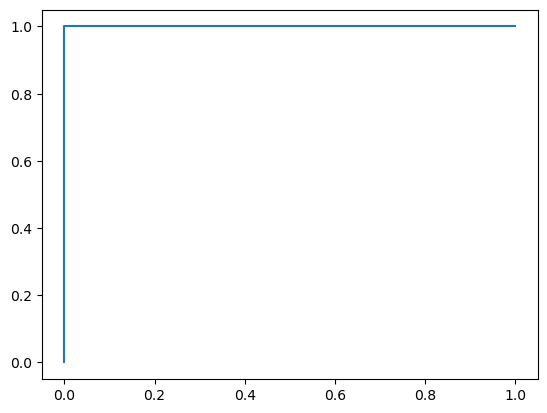

In [252]:
tpr, fpr, _ = roc_curve(y_train, boost_optimal.predict_proba(count_vectorized_x_train)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

0.6006666666666667

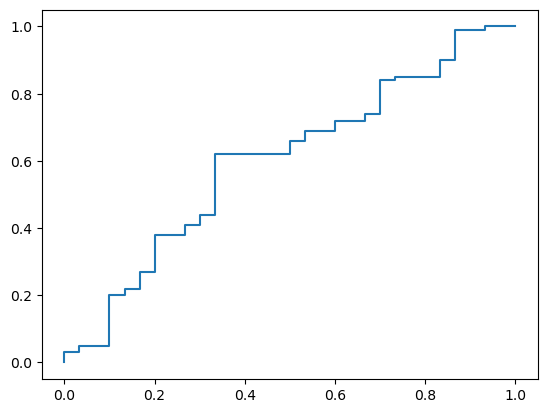

In [253]:
tpr, fpr, _ = roc_curve(y_test, boost_optimal.predict_proba(count_vectorized_x_test)[:, 0])
plt.plot(fpr, tpr)
auc(fpr, tpr)

In [254]:
print('Accuracy test:', accuracy_score(y_test, pred_boost_test))
print('Precision test:', precision_score(y_test, pred_boost_test))
print('Recall test:', recall_score(y_test, pred_boost_test))
print('F1-score test:', f1_score(y_test, pred_boost_test))

Accuracy test: 0.7846153846153846
Precision test: 0.75
Recall test: 0.1
F1-score test: 0.17647058823529416


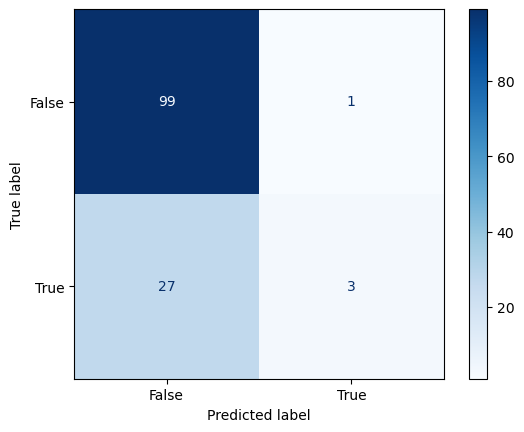

In [255]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, pred_boost_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

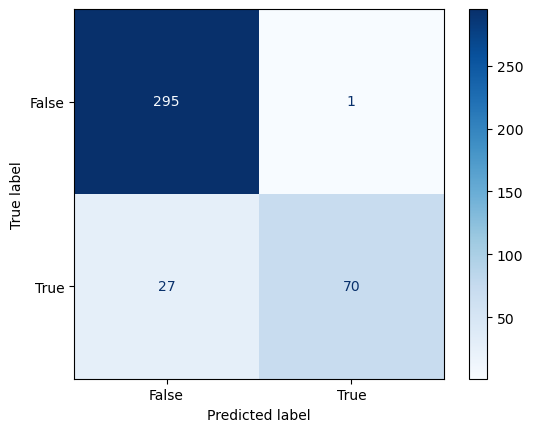

In [256]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y, pred_boost_optimal)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

In [257]:
FP = confusion_matrix.sum(axis=0)[1] - np.diag(confusion_matrix)[1]  
FN = confusion_matrix.sum(axis=0)[0] - np.diag(confusion_matrix)[0]  
TN = np.diag(confusion_matrix)[0]
TP = np.diag(confusion_matrix)[1]

TPR = TP/(TP+FN)
PPV = TP/(TP+FP)

print('Доля выявленного мошенничества:', TPR)
print('Доля предсказанного верно мошенничества:', PPV)

Доля выявленного мошенничества: 0.7216494845360825
Доля предсказанного верно мошенничества: 0.9859154929577465


**Облако слов**

In [258]:
feature_to_coef_boost = { word: coef for word, coef in zip(count_vectorizer.get_feature_names_out(), boost_optimal.feature_importances_) }

fraudwords = []
for best_positive in sorted(feature_to_coef_boost.items(), key=lambda x: x[1], reverse=True):
    if best_positive[1] != 0:
        fraudwords.append(best_positive[0])

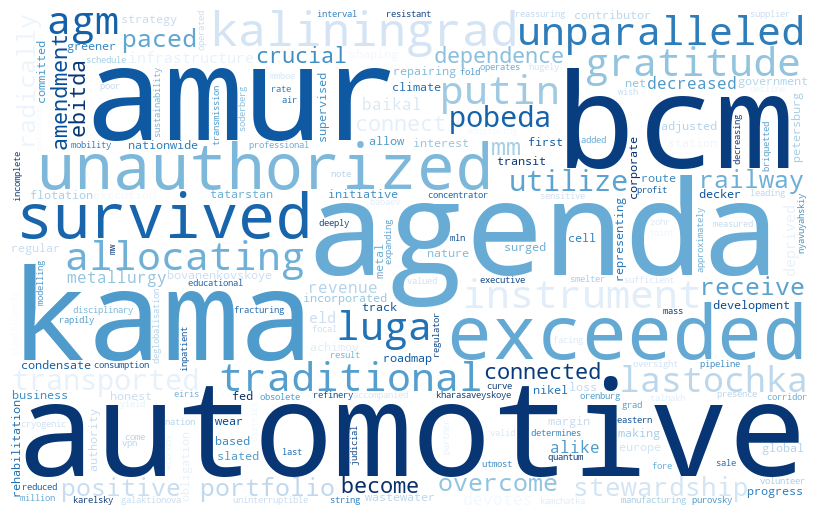

In [259]:
wordsf = " ".join(fraudwords)

wordcloudf = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsf)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudf)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

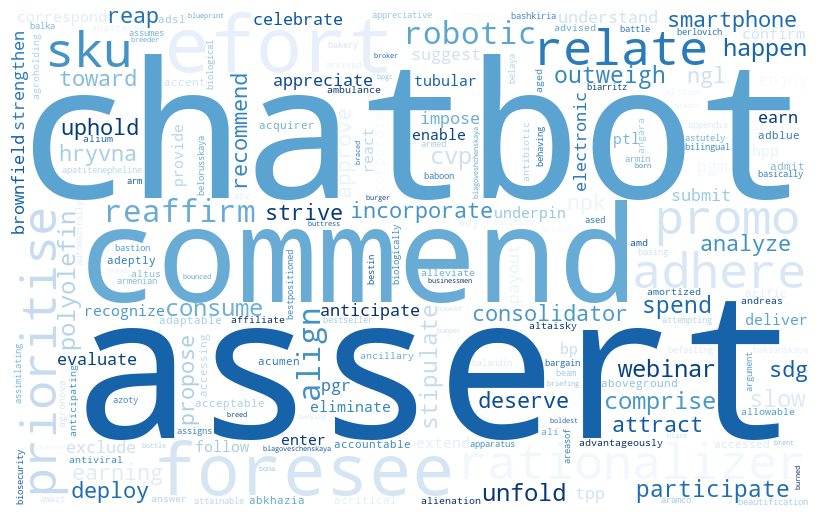

In [260]:
wordsn = " ".join(nonfraudwords)

wordcloudn = WordCloud(
                  width=800, height = 500,   
                  background_color = 'white',
                  colormap = 'Blues',
                  stopwords=stopwords).generate(wordsn)

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.imshow(wordcloudn)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Выбор оптимальной модели

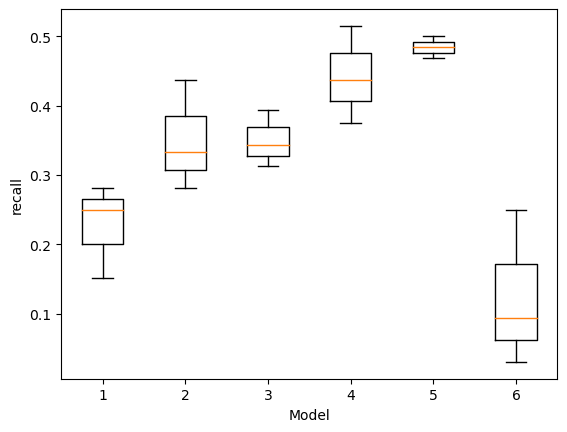

In [262]:
#1
cv_log_best = cross_validate(log_optimal, tfidf_vectorized_x, y, cv = 3, scoring = 'recall')

#2
cv_tree_best = cross_validate(tree_optimal, count_vectorized_x, y, cv = 3, scoring = 'recall')

#3
cv_sgd_best = cross_validate(sgd_optimal1, tfidf_vectorized_x, y, cv = 3, scoring = 'recall')
cv_sgd_best1 = cross_validate(sgd_optimal, count_vectorized_x, y, cv = 3, scoring = 'recall')

#4
cv_svm_best = cross_validate(svm_optimal, tfidf_vectorized_x, y, cv = 3, scoring = 'recall')

#5
cv_boost_best = cross_validate(boost_optimal, count_vectorized_x, y, cv = 3, scoring = 'recall')

data = [cv_log_best['test_score'], cv_tree_best['test_score'], cv_sgd_best['test_score'], 
        cv_sgd_best1['test_score'], cv_svm_best['test_score'], cv_boost_best['test_score']]
plt.boxplot(data)
plt.xlabel("Model")
plt.ylabel("recall")
plt.show()

In [263]:
precisions, recalls, f1scores, accuracys, rocaucs = [], [], [], [], []

def data(score):
    cv_log_best = cross_validate(log_optimal, tfidf_vectorized_x, y, cv = 3, scoring = score)
    cv_tree_best = cross_validate(tree_optimal, count_vectorized_x, y, cv = 3, scoring = score)
    cv_sgd_best = cross_validate(sgd_optimal1, tfidf_vectorized_x, y, cv = 3, scoring = score)
    cv_sgd_best1 = cross_validate(sgd_optimal, count_vectorized_x, y, cv = 3, scoring = score)
    cv_svm_best = cross_validate(svm_optimal, tfidf_vectorized_x, y, cv = 3, scoring = score)
    cv_boost_best = cross_validate(boost_optimal, count_vectorized_x, y, cv = 3, scoring = score)
    return [cv_log_best['test_score'], cv_tree_best['test_score'], cv_sgd_best['test_score'], 
            cv_sgd_best1['test_score'], cv_svm_best['test_score'], cv_boost_best['test_score']]

def average(data, frame):
    for i in data:
        average = 0
        for j in i:
            average += j
        average = average / 3
        frame.append(average)
    return frame

average(data('precision'), precisions)
average(data('recall'), recalls)
average(data('roc_auc'), rocaucs)
average(data('f1'), f1scores)
average(data('accuracy'), accuracys)

[0.7837150127226463,
 0.7022900763358778,
 0.7760814249363869,
 0.7175572519083969,
 0.7735368956743002,
 0.7709923664122137]

In [264]:
model = ['log', 'tree', 'sgd_tfidf', 'sgd_cv', 'svm', 'boost']
metrics_cv = pd.DataFrame({'f1_score': f1scores, 'precision': precisions, 'recall': recalls, 'ROC AUC': rocaucs, 
                        'accuracy': accuracys}, index=model)
metrics_cv

,f1_score,precision,recall,ROC AUC,accuracy
log,0.337117,0.714286,0.227588,0.784789,0.783715
tree,0.366212,0.387370,0.350694,0.580919,0.702290
sgd_tfidf,0.435004,0.574770,0.350063,0.749246,0.776081
sgd_cv,0.434753,0.430931,0.442551,0.728413,0.717557
svm,0.513931,0.548106,0.484533,0.767655,0.773537
boost,0.202654,0.607407,0.124684,0.685056,0.770992


In [265]:
print(metrics_cv.max())

f1_score     0.513931
precision    0.714286
recall       0.484533
ROC AUC      0.784789
accuracy     0.783715
dtype: float64


In [ ]:
#f_scores_fraud = []
#f_scores_nonfraud = []
#precisions = []
#recalls = []
#ROC_AUCs = []
#accuracys = []

#models = ['log_count_vect', 'log_tf_idf', 'log_optimal', 
#          'tree_count_vect', 'tree_tf_idf', 'tree_optimal',
#          'sgd_count_vect', 'sgd_tf_idf', 'sgd_optimal',
#          'svm_count_vect', 'svm_tf_idf', 'svm_optimal', 
#          'boost_count_vect', 'boost_tf_idf', 'boost_optimal']

#def count_metric(metric, model):
#    return metric(y_test, model)
#def count_f1(model):
#    return f1_score(y_test, model, average=None)

#for model in (pred_log1, pred_log2, pred_log_optimal, 
#              pred_tree1, pred_tree2, pred_tree_optimal,
#              pred_sgd1, pred_sgd2, pred_sgd_optimal1, 
#              pred_svm1, pred_svm2, pred_svm_optimal,
#              pred_boost1, pred_boost2, pred_boost_optimal):
#    f_scores_nonfraud.append(count_f1(model)[0])
#    f_scores_fraud.append(count_f1(model)[1])
#    precisions.append(count_metric(precision_score, model))
#    recalls.append(count_metric(recall_score, model))
#    ROC_AUCs.append(count_metric(roc_auc_score, model))
#    accuracys.append(count_metric(accuracy_score, model))

In [ ]:
#metrics = pd.DataFrame({'f_score_nonfraud': f_scores_nonfraud, 'f_score_fraud': f_scores_fraud,
#                       'precision': precisions, 'recall': recalls, 'ROC AUC': ROC_AUCs, 
#                        'accuracy': accuracys}, index=models)
#metrics

In [ ]:
#from nltk.stem.snowball import SnowballStemmer

#stemmer = SnowballStemmer("english")
#df['text'] = df['text'].str.split()
#df['text_stem'] = df['text'].apply(lambda x: [stemmer.stem(i) for i in x if i not in stopwords])

In [ ]:
#df['text_stem']

In [ ]:
#from nltk.stem import PorterStemmer

#ps = PorterStemmer()
#df['text'] = df['text'].str.split()
#df['text_stem1'] = df['text'].apply(lambda x: [ps.stem(i) for i in x if i not in stopwords])

In [ ]:
#df['text_stem1']

In [ ]:
#from nltk.stem import WordNetLemmatizer

#wl = WordNetLemmatizer()
#df['text'] = df['text'].str.split()
#df['text_stem2'] = df['text'].apply(lambda x: [wl.lemmatize(i) for i in x if i not in stopwords])

In [ ]:
#df['text_stem2']